# ベイズ階層線形回帰

確率的機械学習モデルは、将来のデータを予測するだけでなく、不確実性をモデル化することもできます。個別化医療などの分野では、大量のデータがあるかもしれませんが、各患者のデータは比較的少ないものです。各人の予測をカスタマイズするためには、各人のモデル（固有の不確実性を含む）を構築し、これらのモデルを階層的に結合して、他の類似した人から情報を借用できるようにする必要があります [1]。

このチュートリアルの目的は、NumPyroを使ってベイズ階層型線形回帰モデルを実装する方法を示すことです。チュートリアルの動機付けとして、KaggleでホストされているOSIC Pulmonary Fibrosis Progression competitionを使用します。

## タスクの理解

肺線維症は、肺の瘢痕化によって引き起こされる、原因も治療法もわからない疾患です。今回の競技では、患者さんの肺機能低下の度合いを予測することが求められました。肺機能は、肺活量計の出力に基づいて評価されます。肺活量計は、吐き出された空気の量である強制肺活量（FVC）を測定します。

医療用途では，モデルの決定に対する信頼性を評価することが有用です．そこで、各チームをランク付けするための指標は、各予測の正確さと確実性の両方を反映するように設計されています。これは、Laplace Log Likelihoodを改良したものです（詳細は後述します）。

それでは、データを調べて、どんなものか見てみましょう。

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv(
    "https://gist.githubusercontent.com/ucals/"
    "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"
    "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"
    "osic_pulmonary_fibrosis.csv"
)
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


このデータセットでは，ある患者のベースラインの胸部CTスキャンと関連する臨床情報が提供されています．患者は、Week = 0の時点で画像を取得し、約1～2年の間に何度もフォローアップの診察を受け、その時にFVCが測定されます。このチュートリアルでは、患者ID、週数、FVC測定値のみを使用し、その他の情報はすべて破棄します。これらの列のみを使用することで、我々のチームは競争力のあるスコアを得ることができました。これは、特に不確実性の評価が問題の重要な部分を占める場合に、ベイズ型階層線形回帰モデルの力を示しています。

これは実際の医療データなので、FVC測定の相対的なタイミングは、以下の3人のサンプル患者に示されているように、大きく異なります。

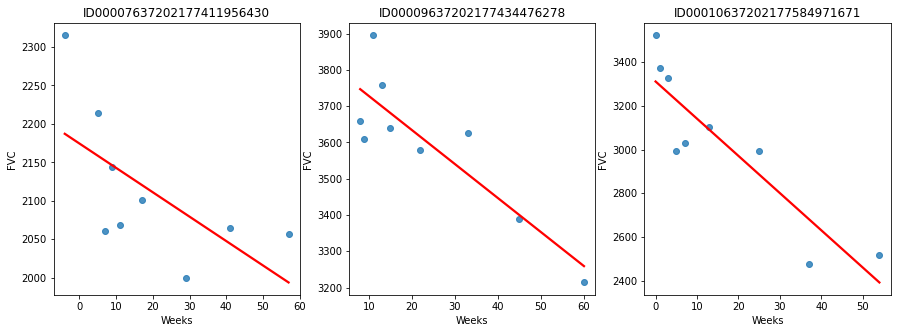

In [5]:
def chart(patient_id, ax):
    data = train[train["Patient"] == patient_id]
    ax.set_title(patient_id)
    ax = sns.regplot(data=data,x="Weeks", y="FVC", ax=ax, ci=None, line_kws={"color": "red"})


f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart("ID00007637202177411956430", axes[0])
chart("ID00009637202177434476278", axes[1])
chart("ID00010637202177584971671", axes[2])

対象となった176名の患者は、平均して9回の受診を行い、FVCを測定した。この訪問は、[-12, 133]の間隔で特定の週に行われた。肺活量の減少は非常に明確です。しかし、患者ごとに大きく異なることがわかりました。

私たちは、[-12, 133]区間内のすべての可能な週におけるすべての患者のFVC測定値を予測し、それぞれの予測に対する信頼度を求められました。言い換えれば、以下のようなマトリクスを記入し、各予測に対する信頼度のスコアを提供するよう求められました。

<img src="https://i.ibb.co/0Z9kW8H/matrix-completion.jpg" alt="drawing" width="600"/>

この課題はベイジアン推論を適用するのに最適でした。しかし、Kaggleコミュニティで共有されたソリューションの大半は、識別的な機械学習モデルを使用していましたが、ほとんどの識別的な手法は現実的な不確実性推定を提供することが非常に困難であるという事実を考慮していませんでした。これらのモデルは通常、損失基準（予測誤差など）を最小化するためにパラメータを最適化する方法で学習されるため、一般的にはパラメータやその後の予測に不確実性を符号化することはありません。多くの手法では、副産物として、または後処理として不確実性推定値を生成することができますが、これらは一般的に、対象となる不確実性分布の統計的に原理的な推定値から自然に導き出されるのではなく、ヒューリスティックに基づいています[2]。

## モデリング

階層化されていない最も単純な線形回帰では、すべてのFVC減少曲線が同じ$\alpha$と$\beta$であると仮定します。これが **pooled model** です。ここでいうpoolとは共有されているくらいのニュアンスで、全患者のデータを完全に共有していることを指します。逆に、各患者が個別のFVC減少曲線を持ち、**これらの曲線は全く関係ない**というモデルを想定することもできます。これが**unpooled model**で、各患者が完全に別々の回帰をしています。

ここでは、中間的な方法を使います。**Partial pooling**です。具体的には、unpooledの場合と同様に、$\alpha$'sと$\beta$'sは患者ごとに異なりますが、**係数はすべて類似している**と仮定します。これをモデル化するには、個々の係数が共通のグループ分布から来ていると仮定します。下の図は、このモデルを図式化したものです。

<img src="https://i.ibb.co/H7NgBfR/Artboard-2-2x-100.jpg" alt="drawing" width="600"/>

数学的には、このモデルは以下の式で表されます。

\begin{align*}
\mu_{\alpha} &\sim \mathcal{N}(0, 100) \\
\sigma_{\alpha} &\sim |\mathcal{N}(0, 100)| \\
\mu_{\beta} &\sim \mathcal{N}(0, 100) \\
\sigma_{\beta} &\sim |\mathcal{N}(0, 100)| \\
\alpha_i &\sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha}) \\
\beta_i &\sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}) \\
\sigma &\sim \mathcal{N}(0, 100) \\
FVC_{ij} &\sim \mathcal{N}(\alpha_i + t \beta_i, \sigma)
\end{align*}

ここで、*t*は週単位の時間です。これらは非常に情報量の少ないプライヤーですが、大丈夫です：私たちのモデルは収束します

このモデルを NumPyro で実装するのはとても簡単です。

In [6]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random

In [7]:
def model(PatientID, Weeks, FVC_obs=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 100.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 100.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(100.0))

    unique_patient_IDs = np.unique(PatientID)
    n_patients = len(unique_patient_IDs)

    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[PatientID] + β[PatientID] * Weeks

    with numpyro.plate("data", len(PatientID)):
        numpyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC_obs)

## モデルをフィッティングする

NumPyroのような確率的プログラミング言語の大きな成果は、モデルの指定と推論を切り離すことです。プライヤー、条件文、データの尤度などで生成モデルを指定した後は、大変な作業をNumPyroの推論エンジンに任せることができます。

これを呼び出すのに必要なのは、わずか数行です。その前に、各患者コードに数値の患者IDを追加しましょう。これはscikit-learnのLabelEncoderで簡単にできます。

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train["PatientID"] = le.fit_transform(train["Patient"].values)

FVC_obs = train["FVC"].values
Weeks = train["Weeks"].values
PatientID = train["PatientID"].values

In [10]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, PatientID, Weeks, FVC_obs=FVC_obs)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:28<00:00, 142.69it/s, 63 steps of size 1.30e-02. acc. prob=0.85]  


## モデルの確認

### 4.1. 学習したパラメータの検査

まず、学習したパラメータを調べてみましょう。そのためには、NumPyroと完全に統合されている[ArviZ](https://arviz-devs.github.io/arviz/)を使います。

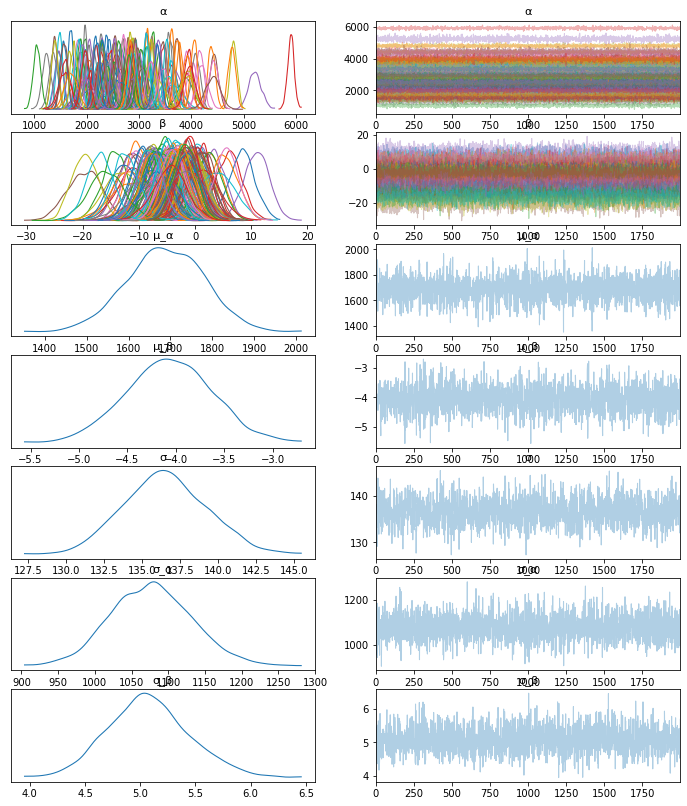

In [12]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

モデルが各患者に合わせたアルファとベータを学習したようですね。

### 4.2. 一部の患者のFVC減少曲線の視覚化

それでは、モデルが予測したFVC低下曲線を視覚的に確認してみましょう。ここでは、FVC表を完全に埋め、すべての欠損値を予測します。最初のステップは、記入するテーブルを作成することです。

In [14]:
pred_template = []
for i in range(train["Patient"].nunique()):
    df = pd.DataFrame(columns=["PatientID", "Weeks"])
    df["Weeks"] = np.arange(-12, 134)
    df["PatientID"] = i
    pred_template.append(df)
pred_template = pd.concat(pred_template, ignore_index=True)

PatientID = pred_template["PatientID"].values
Weeks = pred_template["Weeks"].values
predictive = Predictive(model, posterior_samples, return_sites=["σ", "obs"])
samples_predictive = predictive(random.PRNGKey(0), PatientID, Weeks, None)

In [15]:
df = pd.DataFrame(columns=["Patient", "Weeks", "FVC_pred", "sigma"])
df["Patient"] = le.inverse_transform(pred_template["PatientID"])
df["Weeks"] = pred_template["Weeks"]
df["FVC_pred"] = samples_predictive["obs"].T.mean(axis=1)
df["sigma"] = samples_predictive["obs"].T.std(axis=1)
df["FVC_inf"] = df["FVC_pred"] - df["sigma"]
df["FVC_sup"] = df["FVC_pred"] + df["sigma"]
df = pd.merge(
    df, train[["Patient", "Weeks", "FVC"]], how="left", on=["Patient", "Weeks"]
)
df = df.rename(columns={"FVC": "FVC_true"})
df.head()

,Patient,Weeks,FVC_pred,sigma,FVC_inf,FVC_sup,FVC_true
0,ID00007637202177411956430,-12,2217.808594,162.432083,2055.376465,2380.240723,NaN
1,ID00007637202177411956430,-11,2207.797119,158.908936,2048.888184,2366.706055,NaN
2,ID00007637202177411956430,-10,2210.912109,156.275558,2054.636475,2367.187744,NaN
3,ID00007637202177411956430,-9,2206.692139,155.981186,2050.710938,2362.673340,NaN
4,ID00007637202177411956430,-8,2200.911621,159.709274,2041.202393,2360.620850,NaN


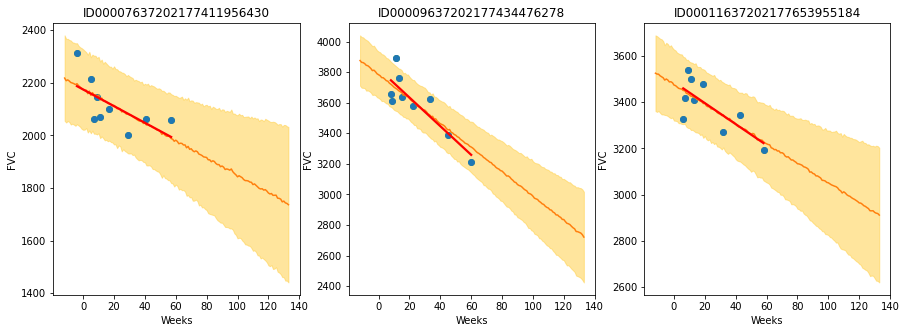

In [17]:
def chart(patient_id, ax):
    data = df[df["Patient"] == patient_id]
    x = data["Weeks"]
    ax.set_title(patient_id)
    ax.plot(x, data["FVC_true"], "o")
    ax.plot(x, data["FVC_pred"])
    ax = sns.regplot(data=data,x="Weeks",y="FVC_true", ax=ax, ci=None, line_kws={"color": "red"})
    ax.fill_between(x, data["FVC_inf"], data["FVC_sup"], alpha=0.5, color="#ffcd3c")
    ax.set_ylabel("FVC")


f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart("ID00007637202177411956430", axes[0])
chart("ID00009637202177434476278", axes[1])
chart("ID00011637202177653955184", axes[2])

期待通りの結果が得られました。

- モデルはベイジアン線形回帰を十分に学習しています。オレンジ色の線（学習したFVC平均の予測値）は、赤色の線（決定論的線形回帰）と非常によく一致しています。しかし、最も重要なことは、薄いオレンジ色の領域（FVC平均値の上下1シグマ）で示される不確実性の予測を学習したことです。
- このモデルは、データポイントがより分散している場所（1人目と3人目の患者）では、より高い不確実性を予測します。逆に、データポイントが密集している場合（2番目の患者）、モデルは高い信頼性を予測します（薄いオレンジ色の領域が狭い）。
- 最後に、すべての患者さんにおいて、将来を見通すほど不確実性が大きくなることがわかります：薄いオレンジ色の領域は、週数が増えるにつれて広がります

### 4.3. 修正ラプラス対数尤度とRMSEの計算

前述したように、コンペティションはLaplace Log Likelihoodの修正版で評価されました。医学的な応用では、モデルの決定に対する信頼性を評価することが有用です。したがって，この指標は，各予測の精度と確実性の両方を反映するように設計されています．

真のFVC測定値ごとに，FVCと信頼度指標（Standard deviation $sigma$）の両方を予測した．この指標は次のように計算された。

$$
\begin{align*}
\sigma_{clipped} &= max(\sigma, 70) \\
\delta &= min(|FVC_{true} - FVC_{pred}|, 1000) \\
metric &= -\dfrac{\sqrt{2}\delta}{\sigma_{clipped}} - \ln(\sqrt{2} \sigma_{clipped})
\end{align*}
$$

誤差は、大きな誤差が結果に悪影響を及ぼすことを避けるため、1000mlで閾値を設定し、信頼値は、FVCのおおよその測定不確かさを反映して70mlでクリップした。最終的なスコアは、すべての(患者、週)ペアのメトリックを平均して算出した。メトリックの値は負の値になり、大きいほど良いことに注意してください。

次に、メトリックとRMSEを計算します。

In [18]:
y = df.dropna()
rmse = ((y["FVC_pred"] - y["FVC_true"]) ** 2).mean() ** (1 / 2)
print(f"RMSE: {rmse:.1f} ml")

sigma_c = y["sigma"].values
sigma_c[sigma_c < 70] = 70
delta = (y["FVC_pred"] - y["FVC_true"]).abs()
delta[delta > 1000] = 1000
lll = -np.sqrt(2) * delta / sigma_c - np.log(np.sqrt(2) * sigma_c)
print(f"Laplace Log Likelihood: {lll.mean():.4f}")

RMSE: 122.1 ml
Laplace Log Likelihood: -6.1374


この数字は何を意味しているのでしょうか？それは、このアプローチを採用すれば、競合するパブリックソリューションのほとんどを凌駕できるということです。不思議なことに、公共のソリューションの大部分は、標準的な決定論的ニューラルネットワークを採用し、分位値損失によって不確実性をモデル化しています。ほとんどの人は、依然として頻度論的アプローチを採用しています。

単一の予測に対する不確実性は、機械学習においてますます重要になり、しばしば必要条件となります。特に、間違った予測の結果が大きい場合には、個々の予測の確率分布を知る必要があります。例えば、Kaggleでは、Lyftがスポンサーとなり、自動運転車の動作予測モデルを構築するための新しいコンペティションを開始しました。"我々は、すべてのエージェントについていくつかの軌道を予測し、それぞれの信頼度スコアを提供することをお願いしています。"

最後に、Pyro/NumPyroの開発者による素晴らしい仕事が、ベイズ法の民主化に貢献し、増え続ける研究者や実務者のコミュニティが、予測を生成するだけでなく、予測の不確実性を評価できるモデルを作成できるようになることを願っています。

## References

1. Ghahramani, Z. Probabilistic machine learning and artificial intelligence. Nature 521, 452–459 (2015). https://doi.org/10.1038/nature14541

2. Rainforth, Thomas William Gamlen. Automating Inference, Learning, and Design Using Probabilistic Programming. University of Oxford, 2017.